In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os

from utils import *
from plot_utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll



In [22]:

# STEP 1: Initialize the analysis parameters and data paths
##### ---------------------------------------------------

data_suffix='lk' #'lambda_minus1'
LL = 512
mode = 'all' # 'all' or 'short'

extract = False
do_basic_analysis = False
do_hyperuniformity_analysis = False
do_merge = False
calc_pcf = False


if data_suffix == 'lk':
    prefix_list = []
    suffix_list = ['025', '10']
    Nframes_list = [400, 400] 
    count_suffix = "_periodic_rm0.1"
    label_list = [r'$K = 0.025$', 
                r'$K = 0.05$',
                r'$K = 0.1$']
elif data_suffix == 'lbc':
    prefix_list = []
    suffix_list = ['3', '4']
    Nframes_list = [400, 400] 
    count_suffix = "_rm0.1"
    label_list = ['free-slip', 'periodic', 'no-slip']
elif data_suffix == 'lam':
    prefix_list = []
    suffix_list = ['05', '2']
    Nframes_list = [100, 100] 
    count_suffix = "_periodic_rm0.1"
    label_list = [r'$\lambda = 0.5$', 
                r'$\lambda = 1$',
            r'$\lambda = 2$']

output_path = f'data\\na{LL}{data_suffix}'
save_path = os.path.join(output_path, 'figs')
if not os.path.exists(save_path):
    os.makedirs(save_path)

defect_list = []

if len(prefix_list) > 0:
    for i, prefix in enumerate(prefix_list):
        data_dict = dict(path = f'X:\\na512exp\\na{LL}{prefix}{data_suffix}', \
                    suffix = 's' if len(prefix) == 0 else prefix, priority = i, LX = LL, Nframes = Nframes_list[i])
        defect_list.append(data_dict)
else:
    for i, suffix in enumerate(suffix_list):
        data_dict = dict(path = f'X:\\na512exp\\na{LL}{data_suffix}{suffix}', \
                    suffix = suffix, priority = 0, LX = LL, Nframes =  Nframes_list[i])
        defect_list.append(data_dict)


ad = AnalyseDefects(defect_list, output_path=output_path, count_suffix=count_suffix,)


# STEP 2: Extract data and perform analysis
##### ---------------------------------------------------

if extract:
    ad.extract_results()
if do_basic_analysis or do_hyperuniformity_analysis:
    # hyperuniformity parameters
    act_idx_bounds=[0,None]
    Npoints_to_fit = 20
    dens_fluc_dict = dict(act_idx_bounds = [0, None], window_idx_bounds = [50 - Npoints_to_fit, None])

    # sfac fitting parameters
    pval_min = 0.05
    Nbounds = [4,5]
    sfac_dict = dict(Npoints_bounds = Nbounds, act_idx_bounds = act_idx_bounds, pval_min = pval_min)

    # temporal correlation parameter
    temp_corr_simple = True
    nlags = None
    ff_idx = None
    acf_dict = {'nlags_frac': 0.5, 'nlags': nlags, 'max_lag': None,\
                    'alpha': 0.3174, 'max_lag_threshold': 0, 'simple_threshold': 0.2, \
                    'first_frame_idx': ff_idx}

    if do_basic_analysis:
        if do_hyperuniformity_analysis:
            print(' sfac n bounds:', Nbounds)
            
            ad.analyze_defects(temp_corr_simple=temp_corr_simple,
                                acf_dict=acf_dict,
                                dens_fluc_dict=dens_fluc_dict, 
                                sfac_dict=sfac_dict, 
                                calc_pcf=calc_pcf)
        else:
            ad.analyze_defects(acf_dict=acf_dict,
                                temp_corr_simple=temp_corr_simple)
if do_merge:
    ad.merge_results()

In [24]:
LL = 512
output_path_ref = f'data\\na{LL}'
mode_ref = 'all' # 'all' or 'short'

defect_list_ref = gen_analysis_dict(LL, mode_ref)
ad2 = AnalyseDefects(defect_list_ref, output_path=output_path_ref)

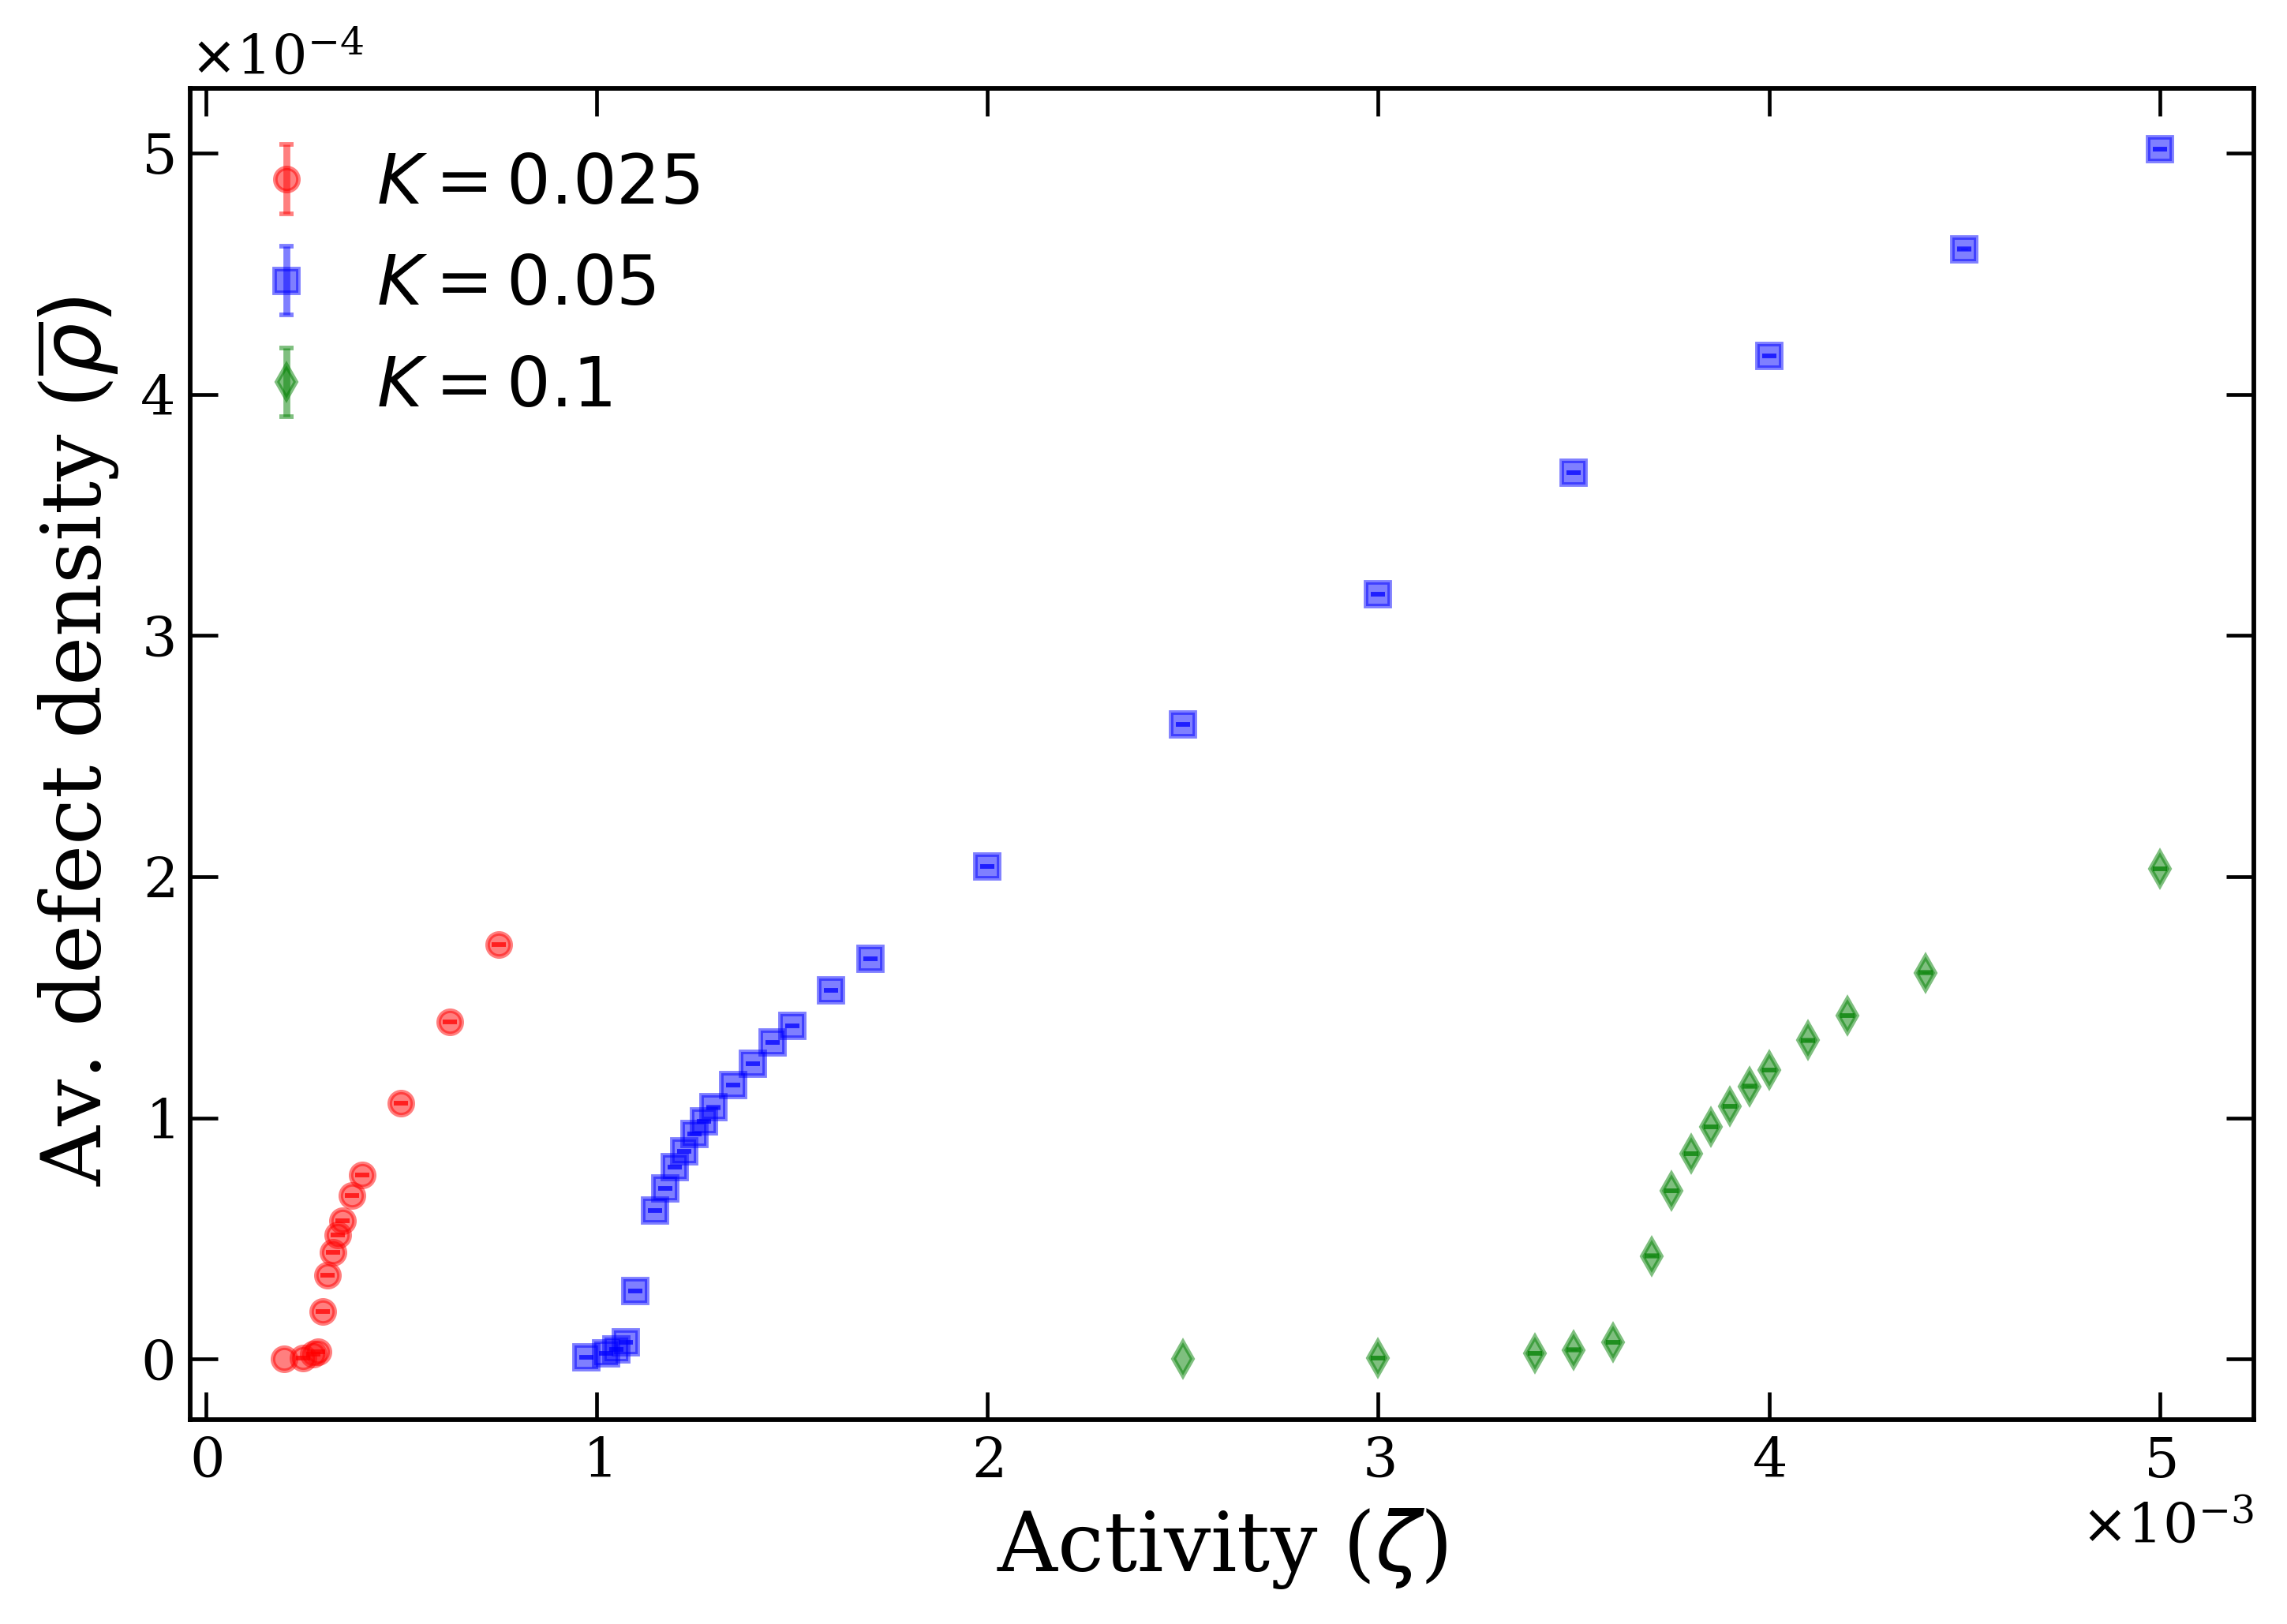

In [58]:
act_list_list = [ad.act_list[0], ad2.act_list_merged, ad.act_list[1]]
marker_list = ['ro', 'bs', 'gd']


fig, ax = plt.subplots(figsize=(7,5))

K_list = [0.025, 0.05, 0.1]


av_defect_list = [ad.get_arrays_av(0)[-1], ad2.get_arrays_av(use_merged=True)[-1], ad.get_arrays_av(1)[-1]]

for i, label in enumerate(label_list):

    act_arr= np.array(act_list_list[i])

    #act_active = #np.sqrt(K_list[i])**1.6# / act_arr)
    scaling = 1/K_list[i] #/0.05 #1/ np.sqrt(act_arr/K_list[i])
    act_scaled = act_arr / scaling # np.sqrt(act_arr / K_list[i])
    #act_scaled = act_arr
    av_def = av_defect_list[i] / LL ** 2
    av_def[:,0] = av_def[:,0] / scaling
    av_def[:,1] = av_def[:,1] / scaling**2

    ax.errorbar(act_scaled, av_def[:,0], av_def[:,1], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)

ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r' Av. defect density ($\overline{\rho})$')
#ax.vlines(x=0.022, ymin = -1e-2, ymax=.6e-2, linestyle='--', color='k', lw = 1)
#ax.hlines(y=0, xmin=0, xmax=.052, linestyle='-', color='k', lw = 1 )

#ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))   
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(.5e-3))     
#ax.set_xlim([0, 0.052])
#ax.set_ylim(ymin=-.05e-2, ymax = .6e-2)
ax.legend(loc='upper left', ncols=1)

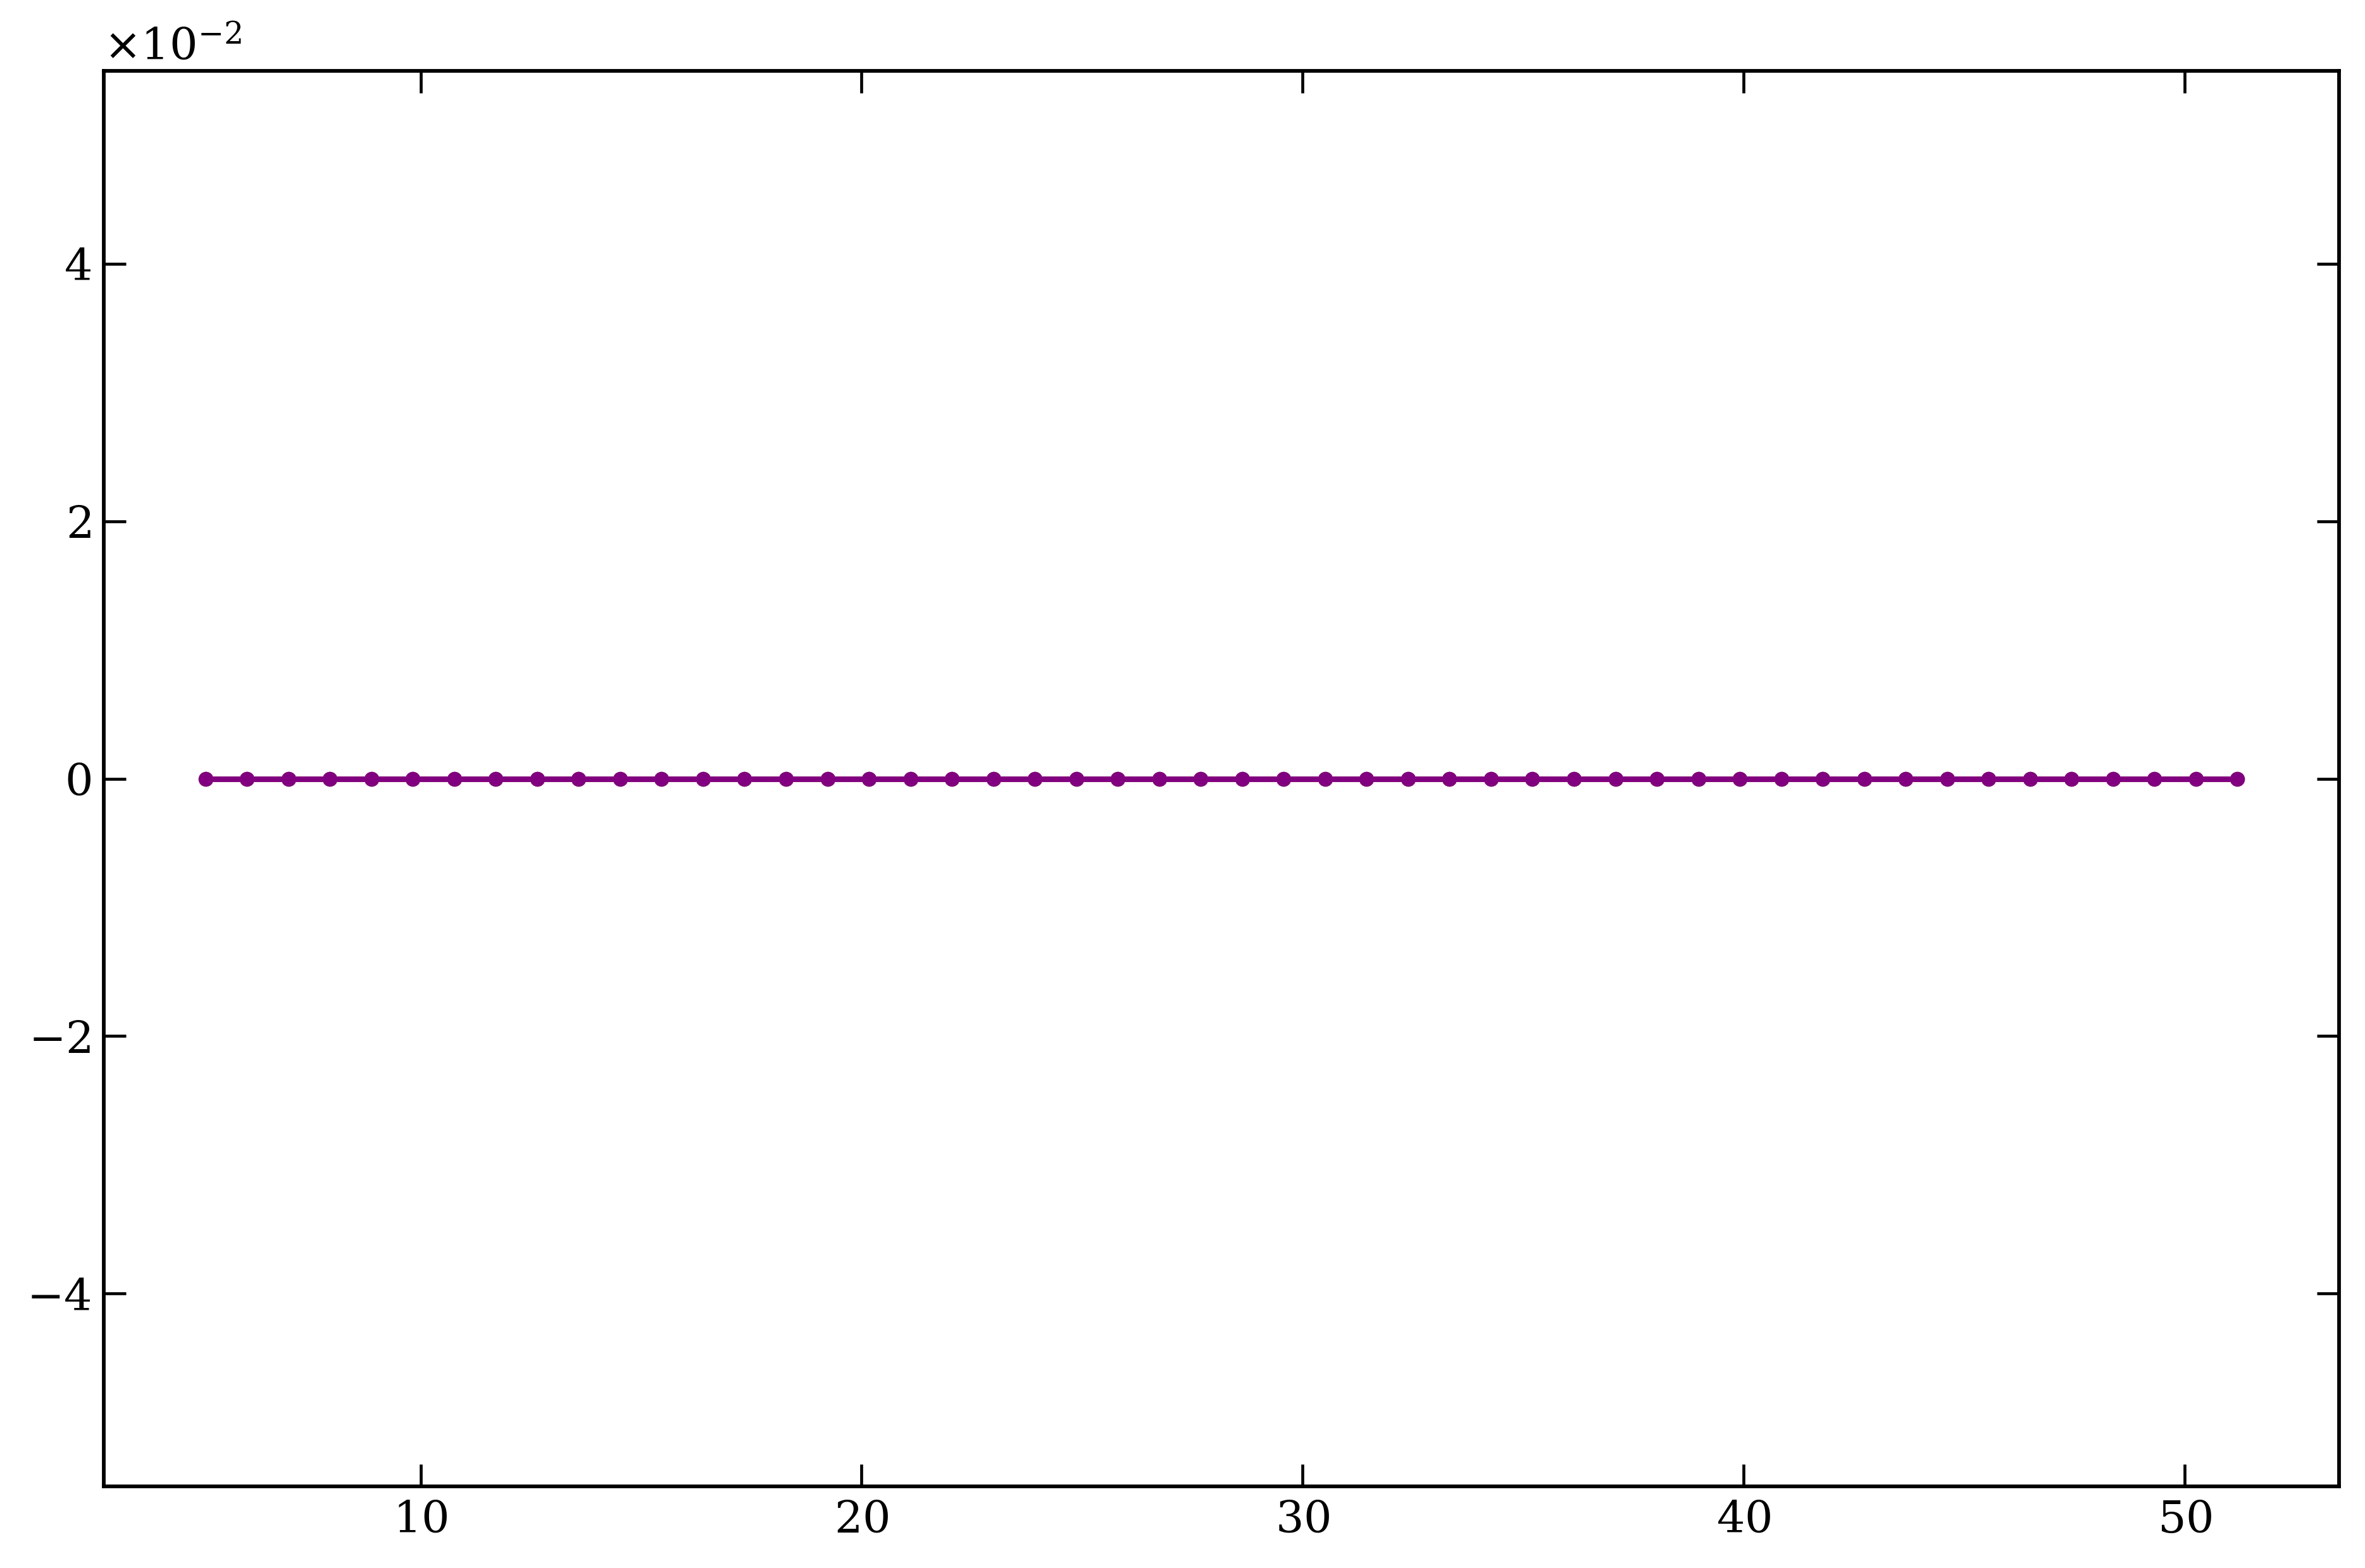

In [16]:
var_counts = np.zeros((len(ad.window_sizes[-1]), len(ad.act_list[-1]), 2))
def_arr_full, av_counts = ad.get_arrays_full(-1)[:2]
conv_list = ad.conv_list[-1]

act_list = ad.act_list[-1]
windows = ad.window_sizes[-1]

for i, _ in enumerate(ad.act_list[-1]):
    vars = np.nanvar(av_counts[conv_list[i]:, :, i, :], axis = 0)
    var_counts[:, i, 0] = np.nanvar(av_counts[conv_list[i]:, :, i, :], axis = (0,-1))
    var_counts[:, i, 1] = np.nanstd(vars, axis = -1) / np.sqrt(ad.Nexp[-1])

for j, act in enumerate(act_list[:4]):
    plt.plot(windows, var_counts[:,j,0], label=act, marker='o', markersize=3, linewidth=1.5)


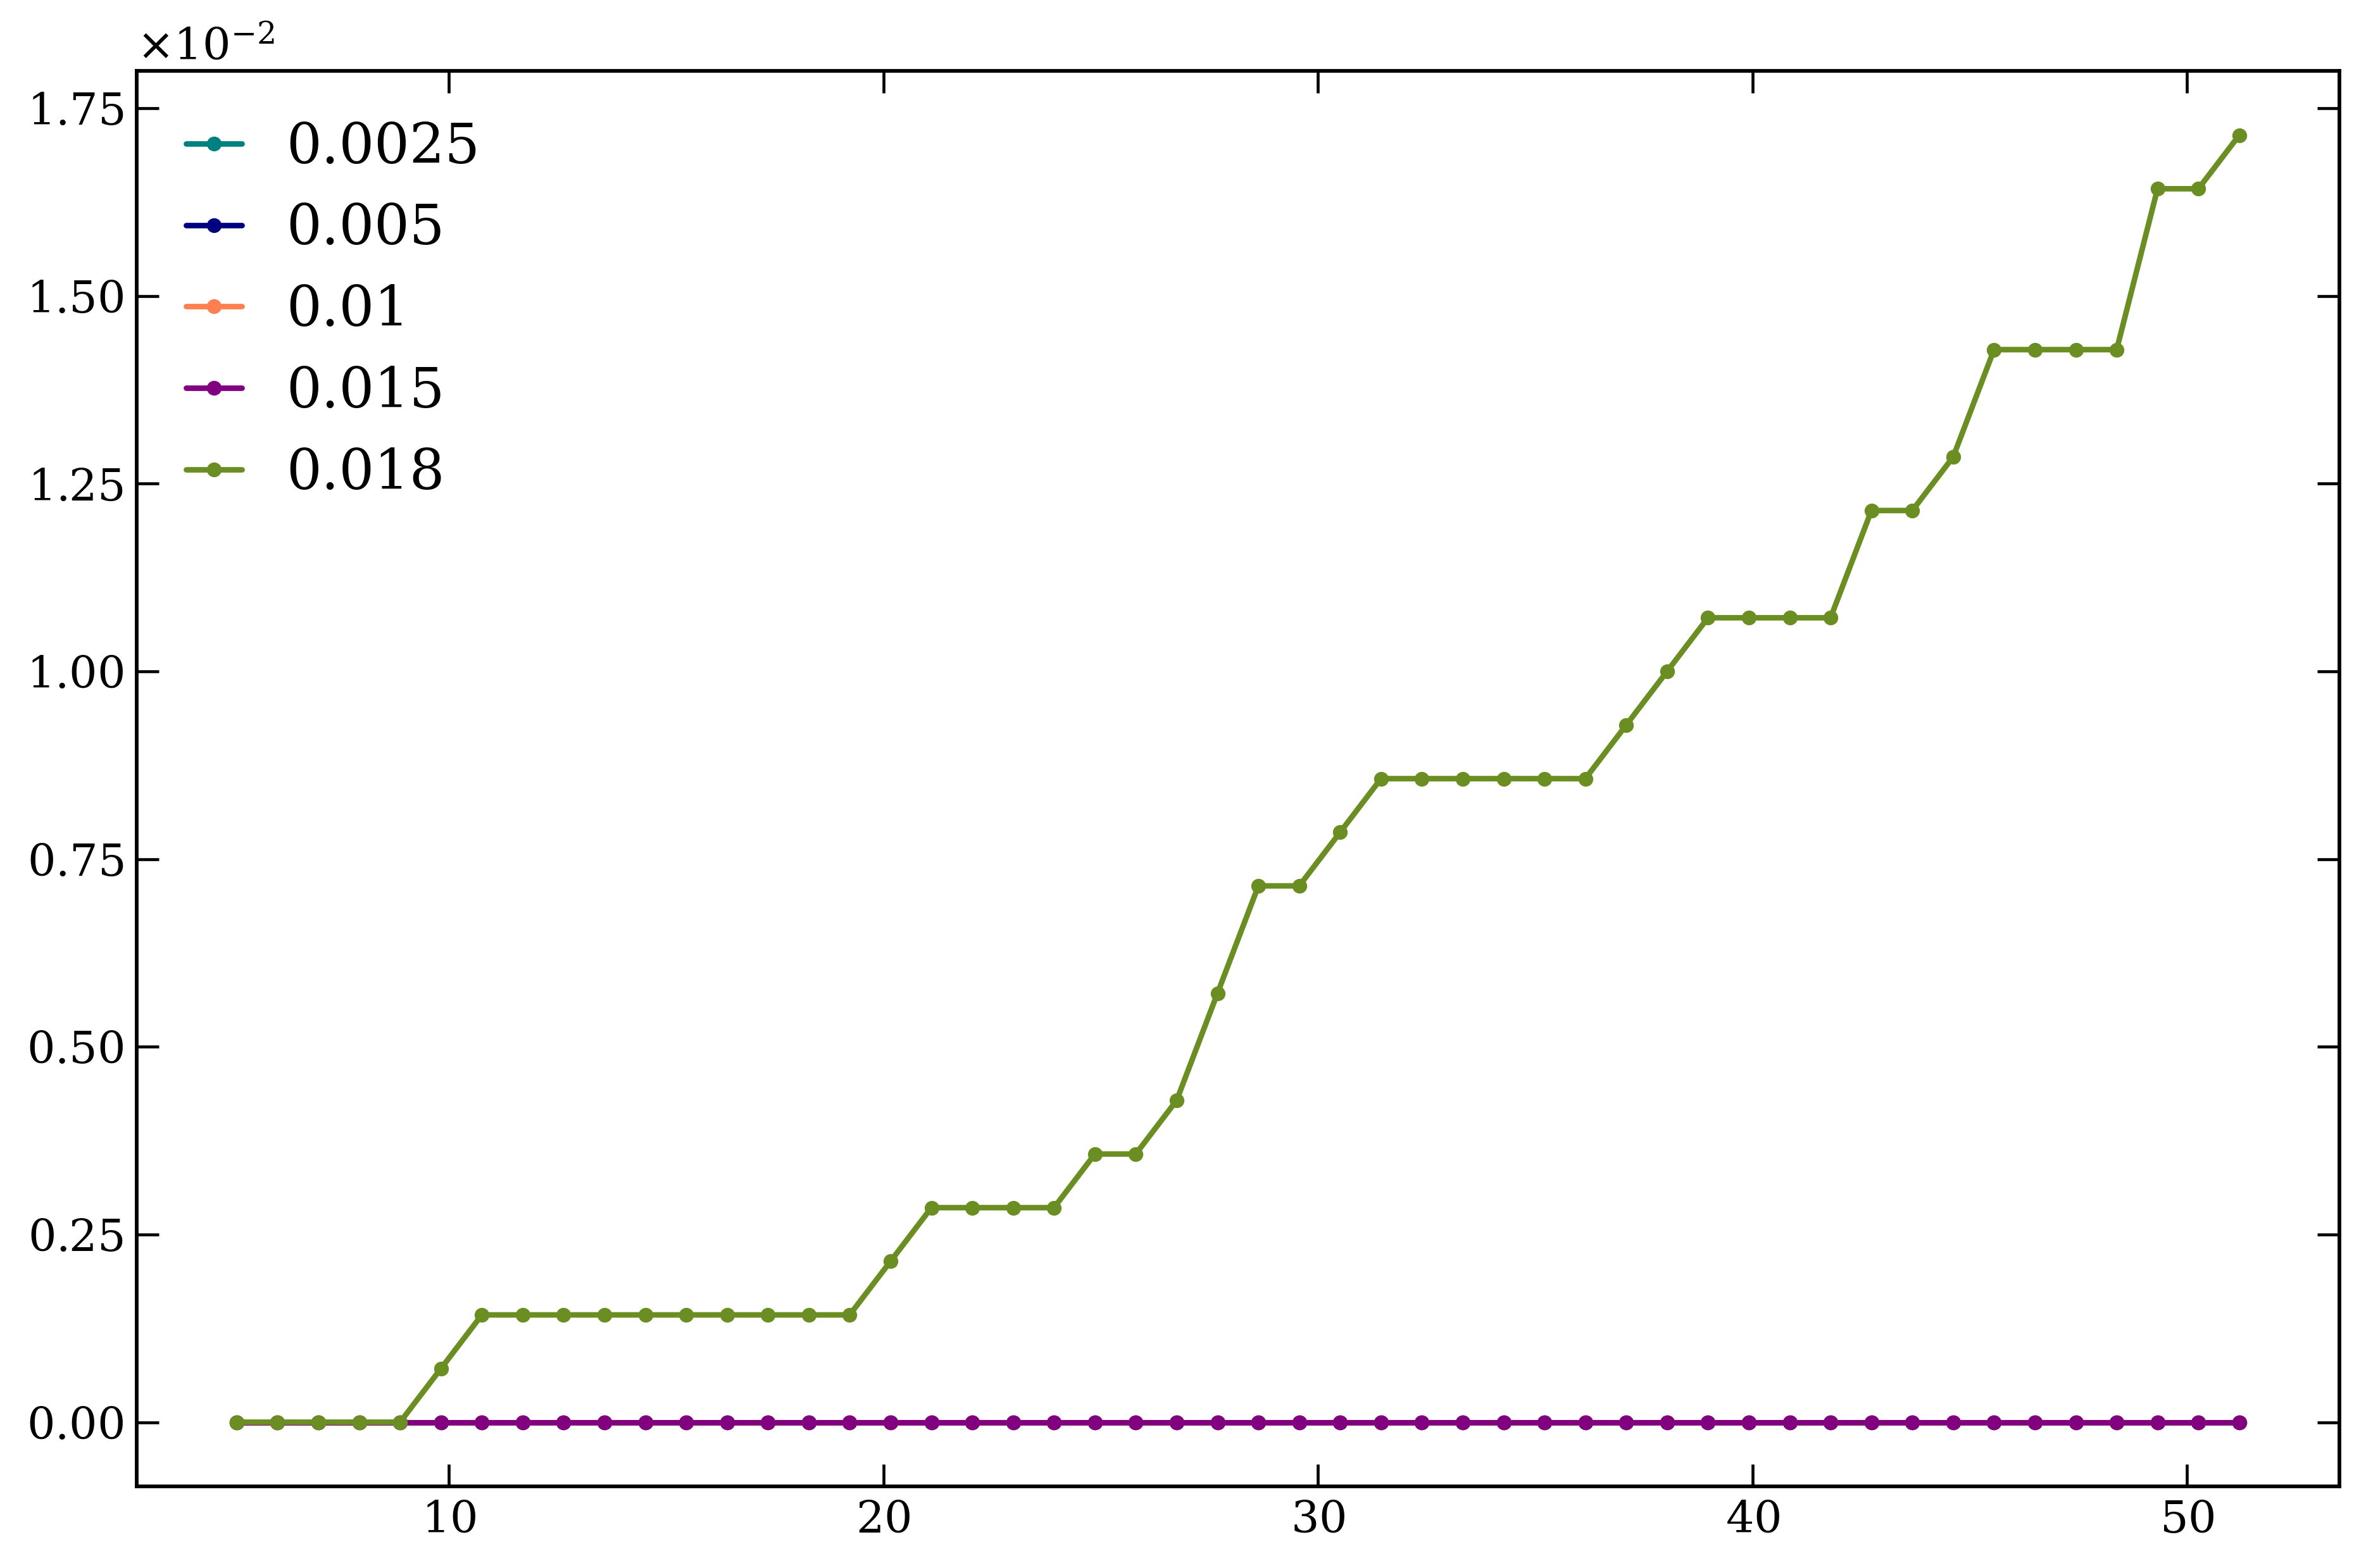

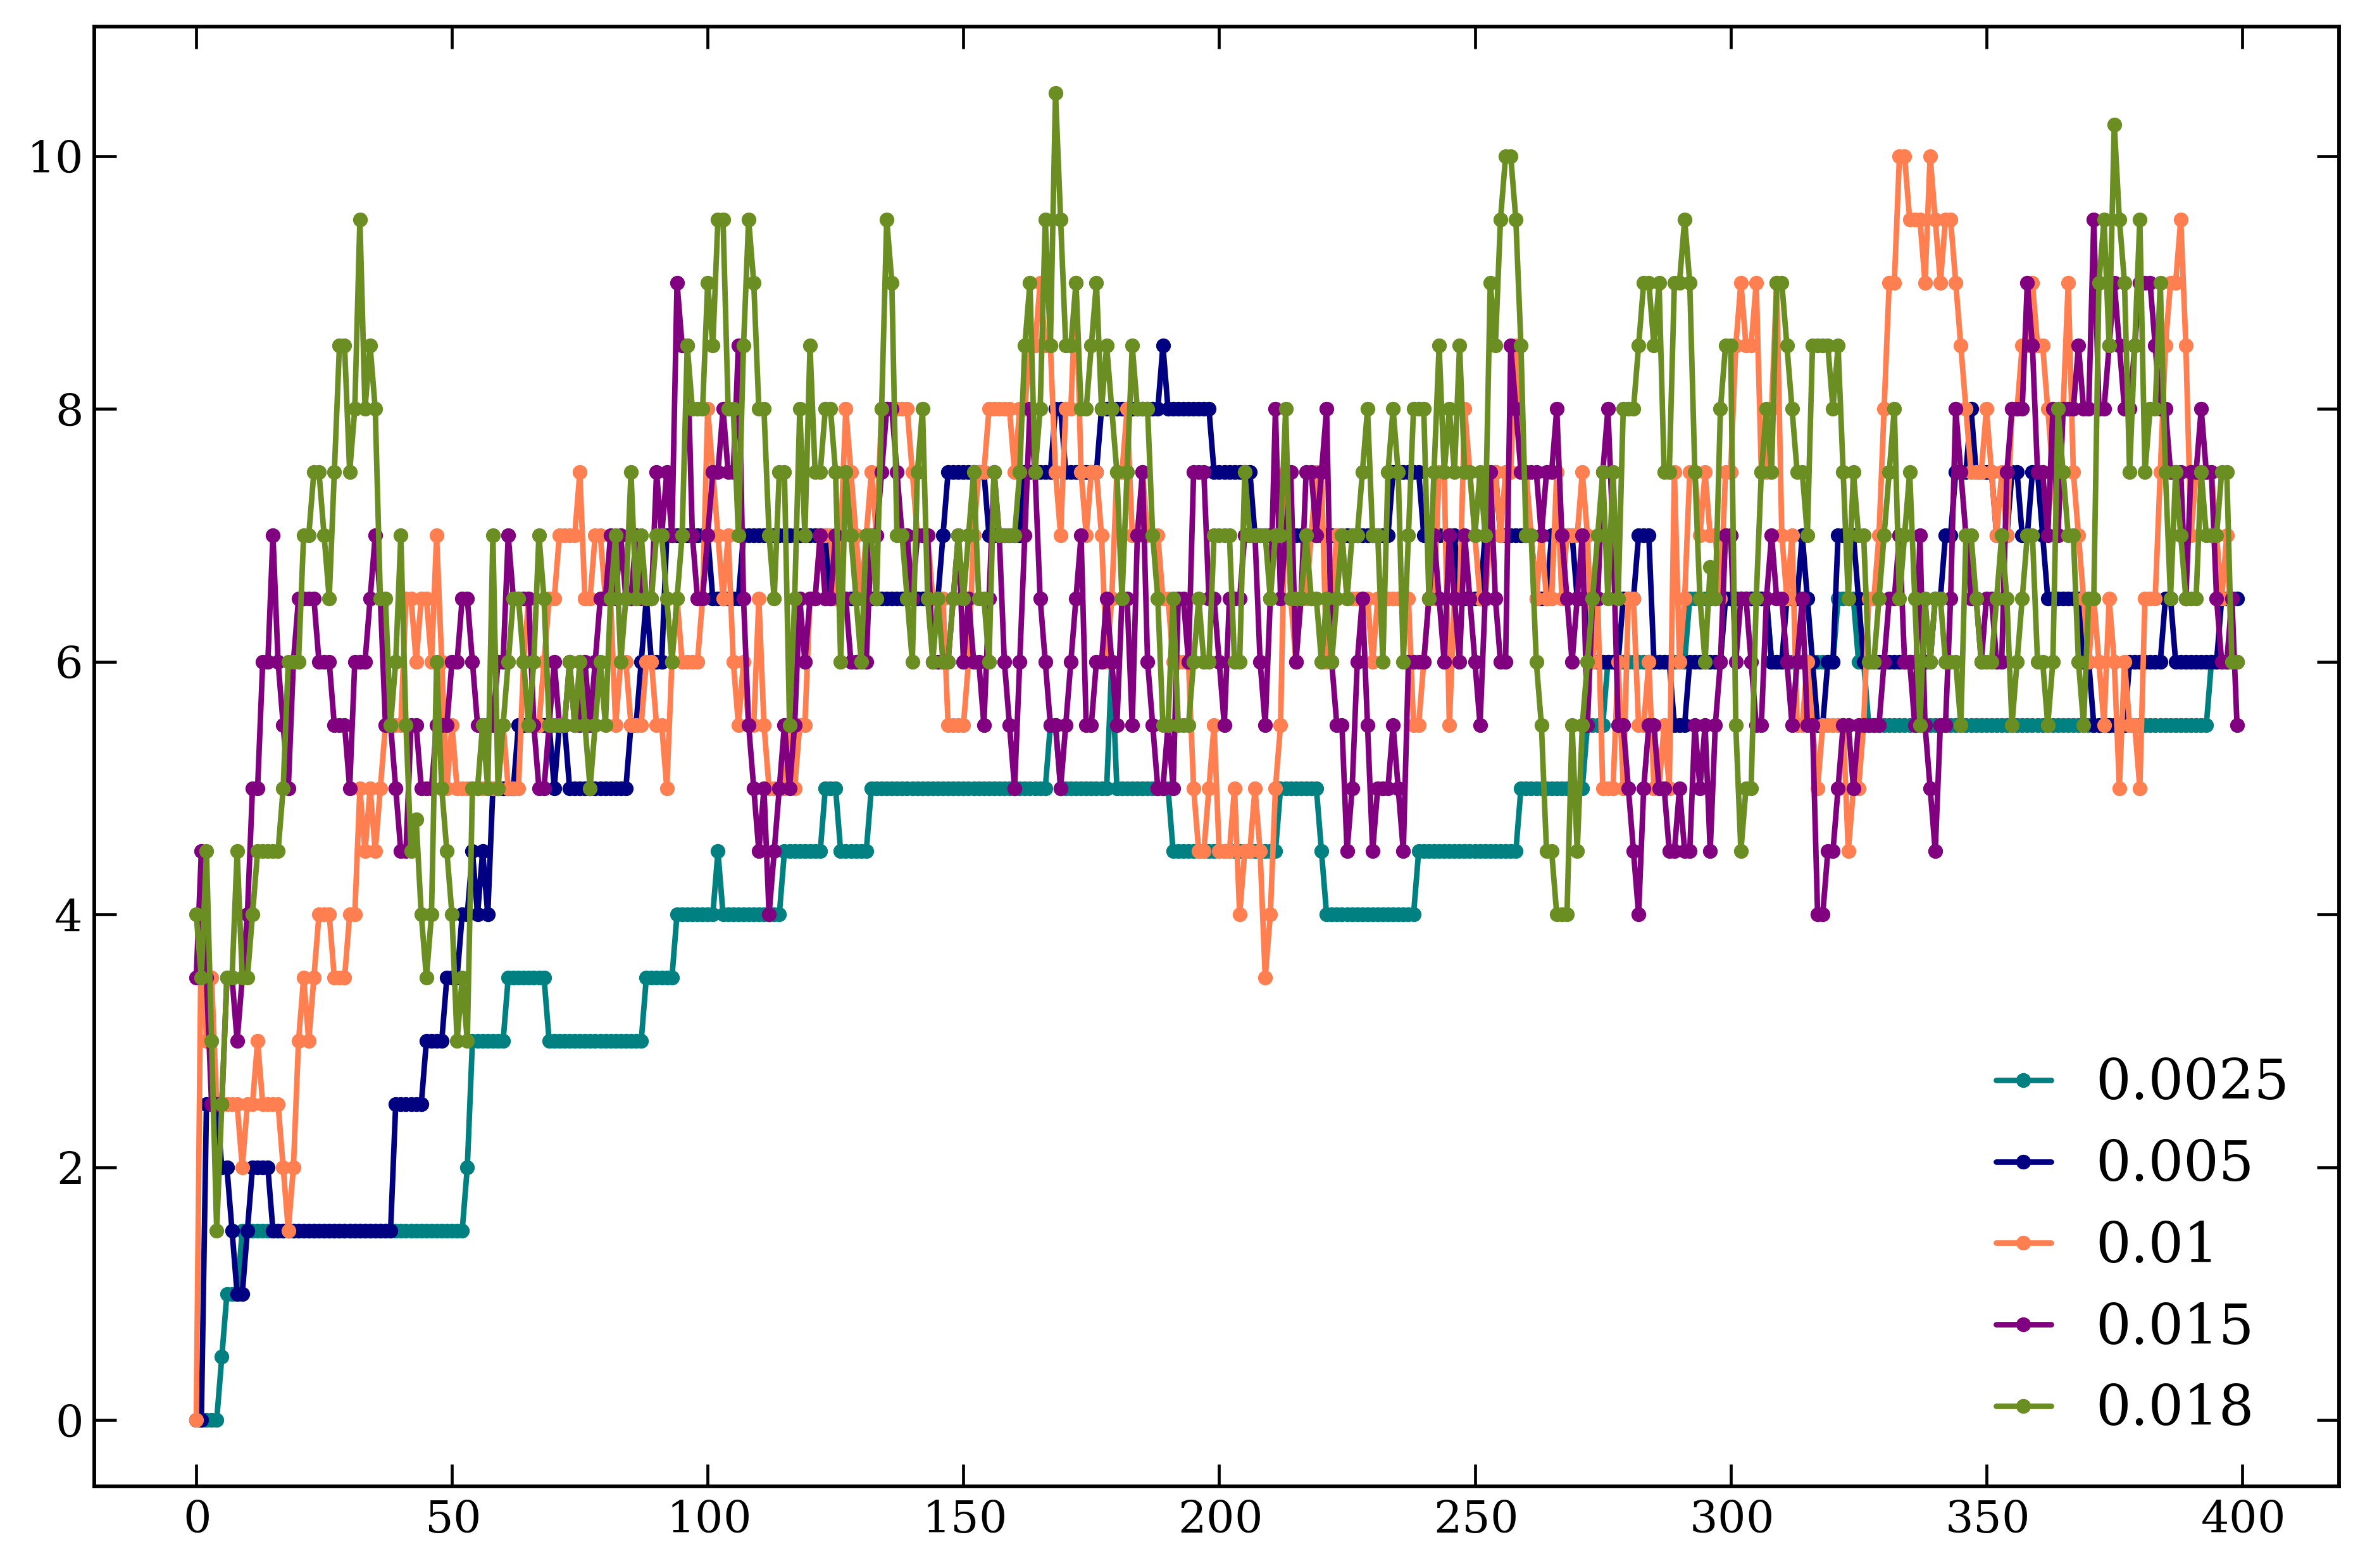

In [20]:

def_arr, var_counts, av_counts_av = ad.get_arrays_av(-1)[:3]
act_list = ad.act_list[-1]
windows = ad.window_sizes[-1]

for j, act in enumerate(act_list[:5]):
    plt.plot(windows, av_counts_av[:,j,0], label=act, marker='o', markersize=3, linewidth=1.5)

plt.legend()
plt.figure()
for i, act in enumerate(act_list[:5]):
    plt.plot(def_arr[:, i,0], label=act, marker='o', markersize=3, linewidth=1.5)

plt.legend()